# CUS 5.13.0 User I/O Before and After Release Deployment

## Procedure

### Load the Data

The data is a CSV flat file; see README.md in the project root directory

### Filter, Clean and Transform the Data

The file contains more than one hundred statistics, but just 2 of them are taken into account for the analysis:

* physical read total IO requests, and
* physical read total bytes

Further, :

* datetime fields have to be transformed into datetime objects.
* the duration of the snapshot intervals must be checked
* the statistics increment in the course of a snapshot interval must be computed
* the data must be checked for database restarts (resetting the statistics)

### Data Analysis

Split the data into 2 dataframes:

* one for the period before release deployment (i.e. running the old release 5.12.1),
* and one for the period after release deployment (i.e. running the new release 5.13.0)

Compare the data

### Load the data

In [1]:
import os
import numpy as np
import pandas as pd

os.chdir('../../data/Baseline.2020-06-11')
df = pd.read_csv('dba-hist-sysstat.dsv', sep=';', \
            names=['start', 'end', 'snapid', 'instance', 'stat', 'value'],
            header=1)
df.head(10)

,start,end,snapid,instance,stat,value
0,2020-05-13 00:00:14,2020-05-13 01:00:25,41927,1,ADG parselock X get attempts,0
1,2020-05-13 00:00:14,2020-05-13 01:00:25,41927,1,ADG parselock X get successes,0
2,2020-05-13 00:00:14,2020-05-13 01:00:25,41927,1,application wait time,26423478
3,2020-05-13 00:00:14,2020-05-13 01:00:25,41927,1,auto extends on undo tablespace,0
4,2020-05-13 00:00:14,2020-05-13 01:00:25,41927,1,background checkpoints completed,3796
5,2020-05-13 00:00:14,2020-05-13 01:00:25,41927,1,background checkpoints started,3796
6,2020-05-13 00:00:14,2020-05-13 01:00:25,41927,1,background timeouts,116862829
7,2020-05-13 00:00:14,2020-05-13 01:00:25,41927,1,Batched IO block miss count,2802075298
8,2020-05-13 00:00:14,2020-05-13 01:00:25,41927,1,Batched IO (bound) vector count,31257017
9,2020-05-13 00:00:14,2020-05-13 01:00:25,41927,1,Batched IO buffer defrag count,11558850


### Filtering and transforming the data; take only the 2 selected statistics

In [2]:
df = df[df.stat.isin(['physical read total IO requests', 'physical read total bytes'])]
df.start = pd.to_datetime(df.start, errors='raise')
df.end = pd.to_datetime(df.end, errors='raise')

## duration of a snapshot
snaplen = df.end - df.start
snaplen.name = 'snaplen'
df = pd.concat([df, snaplen], axis=1)

df.head(10)

,start,end,snapid,instance,stat,value,snaplen
422,2020-05-13 00:00:14,2020-05-13 01:00:25,41927,1,physical read total bytes,161883305902592,01:00:11
424,2020-05-13 00:00:14,2020-05-13 01:00:25,41927,1,physical read total IO requests,1636991568,01:00:11
1101,2020-05-13 00:00:14,2020-05-13 01:00:25,41927,2,physical read total bytes,288673872805376,01:00:11
1103,2020-05-13 00:00:14,2020-05-13 01:00:25,41927,2,physical read total IO requests,4822821721,01:00:11
1780,2020-05-13 01:00:25,2020-05-13 02:00:34,41928,1,physical read total bytes,162020955790336,01:00:09
1782,2020-05-13 01:00:25,2020-05-13 02:00:34,41928,1,physical read total IO requests,1638076663,01:00:09
2459,2020-05-13 01:00:25,2020-05-13 02:00:34,41928,2,physical read total bytes,288761979712000,01:00:09
2461,2020-05-13 01:00:25,2020-05-13 02:00:34,41928,2,physical read total IO requests,4823539809,01:00:09
3138,2020-05-13 02:00:34,2020-05-13 03:00:45,41929,1,physical read total bytes,162135784761856,01:00:11
3140,2020-05-13 02:00:34,2020-05-13 03:00:45,41929,1,physical read total IO requests,1638740086,01:00:11


In [3]:
df.describe()

,snapid,instance,value,snaplen
count,2868.000000,2868.000000,2.868000e+03,2868
mean,42294.960948,1.500000,1.275589e+14,0 days 00:59:59.818688
std,212.051270,0.500087,1.347797e+14,0 days 00:00:15.891085
min,41927.000000,1.000000,1.636992e+09,0 days 00:58:42
25%,42113.000000,1.000000,4.222492e+09,0 days 01:00:02
50%,42294.000000,1.500000,8.094451e+13,0 days 01:00:04
75%,42478.000000,2.000000,2.446867e+14,0 days 01:00:06
max,42662.000000,2.000000,3.380895e+14,0 days 01:01:30


### Preliminary conclusions

From the summary above one can see that the duration of a snapshot varys between 00:58:25 hours and 01:01:30 hours; there is no significant variation.

### Compute the increment between snapshots

In [4]:
df = df.sort_values(['snapid', 'instance', 'stat'], ascending=[1,1,1])
shiftval = df[['snapid', 'instance', 'stat', 'value']].groupby(['instance', 'stat'])['value'].shift(1)
shiftval.name = 'precvalue'  ## value of the precursor snapshot
df = pd.concat([df, shiftval], axis=1)

## drop rows having no precursor
df = df.dropna(axis=0)
df.head(10)

,start,end,snapid,instance,stat,value,snaplen,precvalue
1782,2020-05-13 01:00:25,2020-05-13 02:00:34,41928,1,physical read total IO requests,1638076663,01:00:09,1.636992e+09
1780,2020-05-13 01:00:25,2020-05-13 02:00:34,41928,1,physical read total bytes,162020955790336,01:00:09,1.618833e+14
2461,2020-05-13 01:00:25,2020-05-13 02:00:34,41928,2,physical read total IO requests,4823539809,01:00:09,4.822822e+09
2459,2020-05-13 01:00:25,2020-05-13 02:00:34,41928,2,physical read total bytes,288761979712000,01:00:09,2.886739e+14
3140,2020-05-13 02:00:34,2020-05-13 03:00:45,41929,1,physical read total IO requests,1638740086,01:00:11,1.638077e+09
3138,2020-05-13 02:00:34,2020-05-13 03:00:45,41929,1,physical read total bytes,162135784761856,01:00:11,1.620210e+14
3819,2020-05-13 02:00:34,2020-05-13 03:00:46,41929,2,physical read total IO requests,4826916072,01:00:12,4.823540e+09
3817,2020-05-13 02:00:34,2020-05-13 03:00:46,41929,2,physical read total bytes,288882333648896,01:00:12,2.887620e+14
4498,2020-05-13 03:00:45,2020-05-13 04:00:51,41930,1,physical read total IO requests,1641777405,01:00:06,1.638740e+09
4496,2020-05-13 03:00:45,2020-05-13 04:00:51,41930,1,physical read total bytes,162388210925056,01:00:06,1.621358e+14


In [5]:
df[df.value - df.precvalue < 0].count()

start        0
end          0
snapid       0
instance     0
stat         0
value        0
snaplen      0
precvalue    0
dtype: int64

No negative increments, therefore no database restart within the period under analysis.

### Split dataframe into df5121 (release 5.12.1) and df5130 (release 5.13.0)

In [6]:
df5121 = df[df.end < pd.to_datetime('2020-05-26 00:00:00', errors='raise')]
df5121.describe()

,snapid,instance,value,snaplen,precvalue
count,1208.000000,1208.000000,1.208000e+03,1208,1.208000e+03
mean,42083.589404,1.500000,1.192103e+14,0 days 00:59:59.723509,1.191680e+14
std,89.395708,0.500207,1.270914e+14,0 days 00:00:14.998416,1.270547e+14
min,41928.000000,1.000000,1.638077e+09,0 days 00:59:03,1.636992e+09
25%,42006.000000,1.000000,4.102934e+09,0 days 01:00:02,4.101285e+09
50%,42083.500000,1.500000,8.101310e+13,0 days 01:00:04,8.094428e+13
75%,42161.000000,2.000000,2.154520e+14,0 days 01:00:06,2.153450e+14
max,42237.000000,2.000000,3.106511e+14,0 days 01:00:26,3.106217e+14


In [7]:
df5130 = df[df.end >= pd.to_datetime('2020-05-26 04:00:00', errors='raise')]
df5130.describe()

,snapid,instance,value,snaplen,precvalue
count,1640.000000,1640.000000,1.640000e+03,1640,1.640000e+03
mean,42452.092683,1.500000,1.337645e+14,0 days 00:59:59.874390,1.337244e+14
std,121.554267,0.500153,1.399405e+14,0 days 00:00:16.562712,1.399049e+14
min,42242.000000,1.000000,1.949865e+09,0 days 00:58:42,1.945693e+09
25%,42347.000000,1.000000,4.550422e+09,0 days 01:00:02,4.547329e+09
50%,42452.500000,1.500000,9.576866e+13,0 days 01:00:04,9.567985e+13
75%,42557.000000,2.000000,2.502727e+14,0 days 01:00:06,2.501900e+14
max,42662.000000,2.000000,3.380895e+14,0 days 01:01:30,3.380434e+14


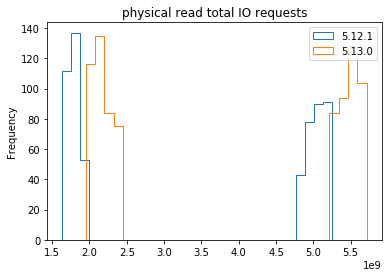

In [13]:
import matplotlib.pyplot as plt

plt.figure()
df5121[df5121.stat=='physical read total IO requests']['value'].plot(\
    kind="hist",bins=30,fill=False,histtype='step',label='5.12.1')
df5130[df5130.stat=='physical read total IO requests']['value'].plot(\
    kind="hist",bins=30,fill=False,histtype='step',label='5.13.0')
plt.title('physical read total IO requests')
plt.legend()
plt.show()

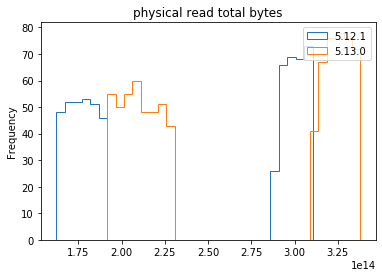

In [9]:
plt.figure()
df5121[df5121.stat=='physical read total bytes']['value'].plot(\
    kind="hist",bins=30,fill=False,histtype='step',label='5.12.1')
df5130[df5130.stat=='physical read total bytes']['value'].plot(\
    kind="hist",bins=30,fill=False,histtype='step',label='5.13.0')
plt.title('physical read total bytes')
plt.legend()
plt.show()

### Conclusions

1. For each release the histogram shows two distinct peaks, corresponding to the two database instances. As some applications run on one of the database host, it is plausible that User I/O is different between the two instances.

2. For each database instance, both statistics (User I/O total number of requests, and total number of bytes physically read) unambiguously show higer values since deployment of the new release.

### Look at each database instance separately

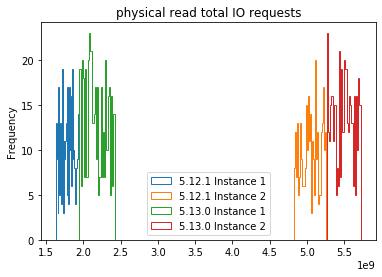

In [22]:
df5121_1 = df5121[df5121.instance == 1]
df5121_2 = df5121[df5121.instance == 2]
df5130_1 = df5130[df5130.instance == 1]
df5130_2 = df5130[df5130.instance == 2]

plt.figure()
df5121_1[df5121_1.stat=='physical read total IO requests']['value'].plot(
    kind="hist",bins=30,fill=False,histtype='step',label='5.12.1 Instance 1')
df5121_2[df5121_2.stat=='physical read total IO requests']['value'].plot(
    kind="hist",bins=30,fill=False,histtype='step',label='5.12.1 Instance 2')
df5130_1[df5130_1.stat=='physical read total IO requests']['value'].plot(
    kind="hist",bins=30,fill=False,histtype='step',label='5.13.0 Instance 1')
df5130_2[df5130_2.stat=='physical read total IO requests']['value'].plot(
    kind="hist",bins=30,fill=False,histtype='step',label='5.13.0 Instance 2')
plt.title('physical read total IO requests')
plt.legend()
plt.show()

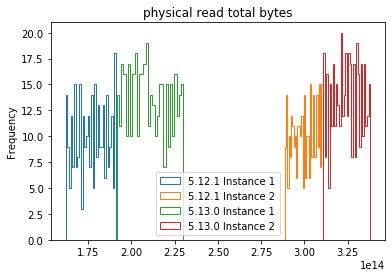

In [21]:
plt.figure()
df5121_1[df5121_1.stat=='physical read total bytes']['value'].plot(
    kind="hist",bins=30,fill=False,histtype='step',label='5.12.1 Instance 1')
df5121_2[df5121_2.stat=='physical read total bytes']['value'].plot(
    kind="hist",bins=30,fill=False,histtype='step',label='5.12.1 Instance 2')
df5130_1[df5130_1.stat=='physical read total bytes']['value'].plot(
    kind="hist",bins=30,fill=False,histtype='step',label='5.13.0 Instance 1')
df5130_2[df5130_2.stat=='physical read total bytes']['value'].plot(
    kind="hist",bins=30,fill=False,histtype='step',label='5.13.0 Instance 2')
plt.title('physical read total bytes')
plt.legend()
plt.show()

### For completeness: Mann-Whitney U-test for "physical read total bytes"

**Null hypothesis:** 
Median of release 5.12.1, instance 1, is equal or higher than median of release 5.13.0, instance 1

**Alternative hypothesis:**
Median of release 5.12.1, instance 1, is less than median of release 5.13.0, instance 1

In [23]:
from scipy import stats

p_bytes_1 = stats.mannwhitneyu(
   df5121_1[df5121_1.stat=='physical read total bytes']['value'],
   df5130_1[df5130_1.stat=='physical read total bytes']['value'],                               
   use_continuity=True, alternative='less')

print(f'p-value is {p_bytes_1.pvalue}')

p-value is 1.2994113080267538e-115


**Conclusion:** Null hypothesis is rejected in favour to the alternative hypothesis.

Test omitted for instance 2.

### Mann-Whitney U-test for "physical read total IO requests"

**Null hypothesis:** 
Median of release 5.12.1, instance 1, is equal or higher than median of release 5.13.0, instance 1

**Alternative hypothesis:**
Median of release 5.12.1, instance 1, is less than median of release 5.13.0, instance 1

In [25]:
p_bytes_1 = stats.mannwhitneyu(
   df5121_1[df5121_1.stat=='physical read total IO requests']['value'],
   df5130_1[df5130_1.stat=='physical read total IO requests']['value'],                               
   use_continuity=True, alternative='less')

print(f'p-value is {p_bytes_1.pvalue}')

p-value is 1.2994113080267538e-115


**Conclusion:** Null hypothesis is rejected in favour to the alternative hypothesis.

Test omitted for instance 2.